## Data Preprocess for real data
Including following tasks
- Data selection for given time period
- Find target route using K-means clustering
- Determine waypoints (intermediate nodes) using DBSCAN
- Extract sub-grids and save

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import math

from itertools import permutations
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix

In [2]:
# setup seed
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True

SEED = 0
seed_everything(SEED)

In [3]:
if not os.path.exists('out'):
    os.mkdir('out')

In [4]:
PATH_START = (121.46, 31.22) #(CNWGQ: 31.22N, 121.46E) 
PATH_END = (174.77, -36.87) #(NZAKL: 36.87S 174.77E)
THRESHOLD = 0.5

In [5]:
df = pd.read_csv('rf_dtmmsi.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df

,TRKG_NO,MMSI_CD,VSL_NM,AIS_DATETIME,LAT,LON,SPD
0,VTR2014041610008,209752000_4,NOBLE REGOR,20140428132100,31.1663,122.1978,63.0
1,VTR2014041610008,209752000_4,NOBLE REGOR,20140428133154,31.1811,122.1737,82.0
2,VTR2014041610008,209752000_4,NOBLE REGOR,20140428134204,31.1953,122.1506,81.0
3,VTR2014041610008,209752000_4,NOBLE REGOR,20140428135115,31.2116,122.1250,99.0
4,VTR2014041610008,209752000_4,NOBLE REGOR,20140428140124,31.2301,122.0927,102.0
...,...,...,...,...,...,...,...
19199,VTR2014071815805,218485000_7,HANSA LIBERTY,20140811125806,-40.4581,177.1012,131.0
19200,VTR2014071815805,218485000_7,HANSA LIBERTY,20140811142137,-40.7383,176.8104,129.0
19201,VTR2014071815805,218485000_7,HANSA LIBERTY,20140811203557,-41.9590,175.5246,125.0
19202,VTR2014071815805,218485000_7,HANSA LIBERTY,20140811205147,-42.0084,175.4731,123.0


In [6]:
len(df['TRKG_NO'].unique()), len(df['MMSI_CD'].unique()), len(df['VSL_NM'].unique())

(18, 9, 5)

In [7]:
df.groupby(['TRKG_NO', 'MMSI_CD']).size()

TRKG_NO           MMSI_CD    
VTR2014041610008  209752000_4     339
VTR2014041723249  209752000_4     737
VTR2014041936662  209752000_4     299
VTR2014050136065  218575000_5    1361
VTR2014050239888  218575000_5    1243
VTR2014050240160  218575000_5    1653
VTR2014052283395  218485000_6    1257
VTR2014052942937  305096000_6     624
VTR2014053056437  218485000_5    1052
VTR2014060695787  209752000_6     784
VTR2014061238208  636091255_6     984
VTR2014061240704  636091255_6    1316
VTR2014061354223  636091255_6    1249
VTR2014061354240  636091255_6    1228
VTR2014061773692  218575000_6    1733
VTR2014062008681  218575000_6    1351
VTR2014071054804  218485000_7    1010
VTR2014071815805  218485000_7     984
dtype: int64

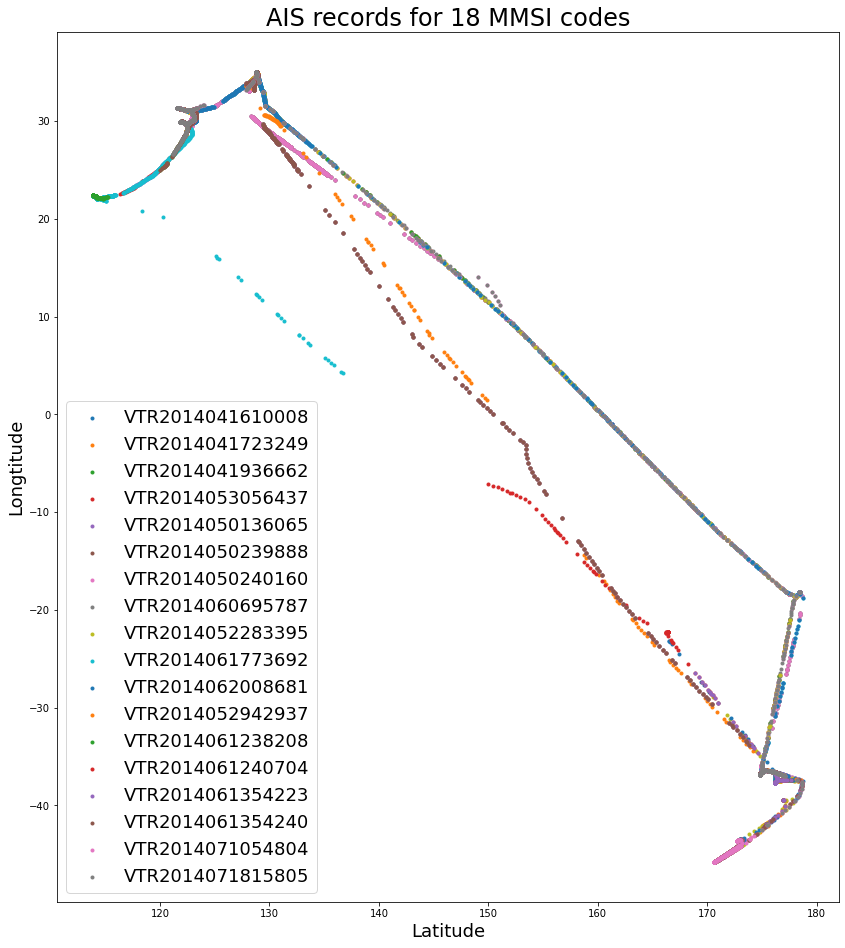

In [8]:
plt.figure(figsize=(14,16))
for idx in df['TRKG_NO'].unique():
    df_selected = df[df['TRKG_NO']==idx]
    plt.scatter(x=df_selected['LON'], y=df_selected['LAT'], marker='.')
plt.legend(df['TRKG_NO'].unique(), fontsize=18)
plt.title('AIS records for 18 MMSI codes', fontsize=24)
plt.xlabel('Latitude', fontsize=18)
plt.ylabel('Longtitude', fontsize=18)
plt.show()

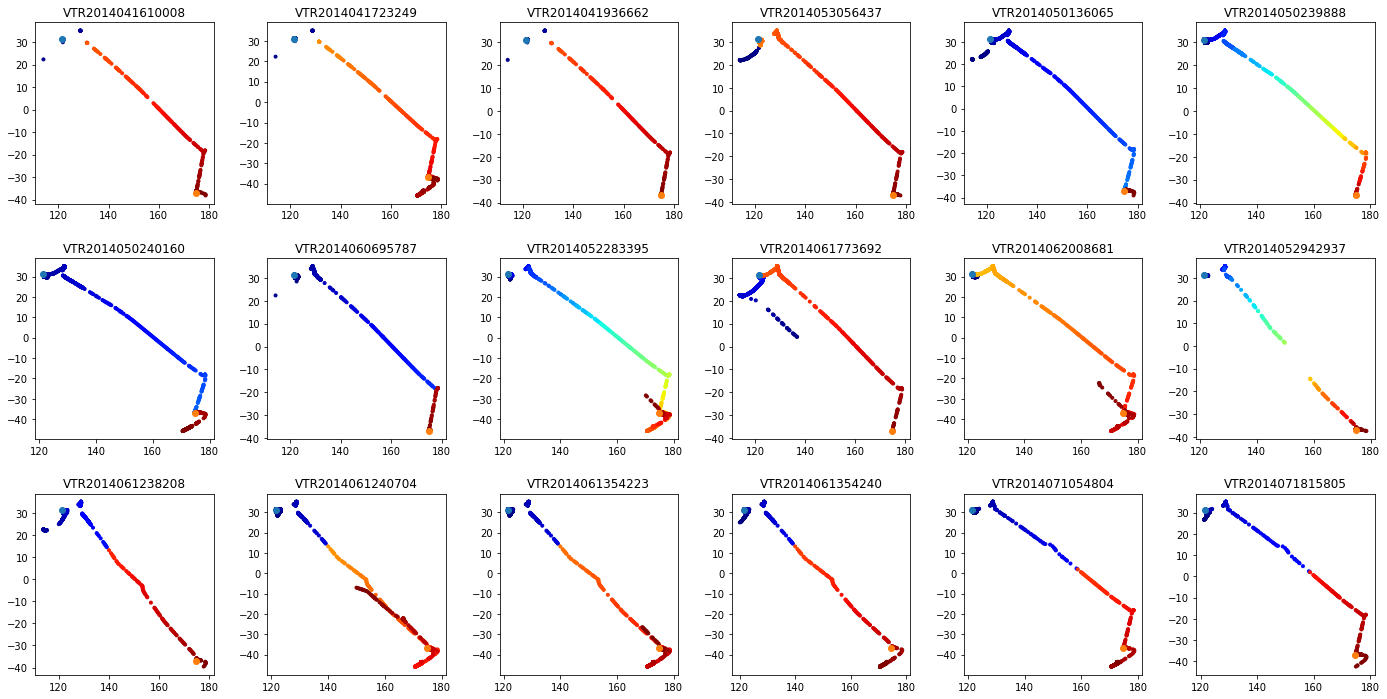

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

i = 0
for row in ax:
    for col in row:
        idx = df['TRKG_NO'].unique()[i]
        df_selected = df[df['TRKG_NO']==idx]
        col.scatter(x=df_selected['LON'], y=df_selected['LAT'], c=df_selected['AIS_DATETIME'], cmap='jet', marker='.')
        col.scatter(x=PATH_START[0], y=PATH_START[1])
        col.scatter(x=PATH_END[0], y=PATH_END[1])
        col.set_title(idx)
        i += 1

In [10]:
df_filtered_list = []
for idx in df['TRKG_NO'].unique():
    df_selected = df[df['TRKG_NO']==idx]
    
    # Sort the value by AIS datetime
    df_selected_sorted = df_selected.copy()
    df_selected_sorted.sort_values(by=['AIS_DATETIME'], ascending=True , inplace=True)
    df_selected = df_selected_sorted
    
    # selected data point near start region
    df_selected_start = df_selected[df_selected['LON'].between(PATH_START[0]-THRESHOLD, PATH_START[0]+THRESHOLD) 
                                    & df_selected['LAT'].between(PATH_START[1]-THRESHOLD, PATH_START[1]+THRESHOLD)]
    start_datetime = df_selected_start.iloc[-1]['AIS_DATETIME']

    # selected data point near end region
    df_selected_end = df_selected[df_selected['LON'].between(PATH_END[0]-THRESHOLD, PATH_END[0]+THRESHOLD)
                                 & df_selected['LAT'].between(PATH_END[1]-THRESHOLD, PATH_END[1]+THRESHOLD)]
    end_datetime = df_selected_end.iloc[0]['AIS_DATETIME']
    
    # only use the data between start_datetime and end_datetime
    df_selected_filtered = df_selected[df_selected['AIS_DATETIME'].between(start_datetime, end_datetime)]
    df_filtered_list.append(df_selected_filtered)
    print('Filter data {}: {} / {}'.format(idx, len(df_selected_filtered), len(df_selected))) 

Filter data VTR2014041610008: 194 / 339
Filter data VTR2014041723249: 194 / 737
Filter data VTR2014041936662: 195 / 299
Filter data VTR2014053056437: 360 / 1052
Filter data VTR2014050136065: 689 / 1361
Filter data VTR2014050239888: 607 / 1243
Filter data VTR2014050240160: 607 / 1653
Filter data VTR2014060695787: 367 / 784
Filter data VTR2014052283395: 360 / 1257
Filter data VTR2014061773692: 503 / 1733
Filter data VTR2014062008681: 503 / 1351
Filter data VTR2014052942937: 263 / 624
Filter data VTR2014061238208: 379 / 984
Filter data VTR2014061240704: 343 / 1316
Filter data VTR2014061354223: 343 / 1249
Filter data VTR2014061354240: 343 / 1228
Filter data VTR2014071054804: 242 / 1010
Filter data VTR2014071815805: 242 / 984


In [11]:
df_filtered = pd.concat(df_filtered_list)

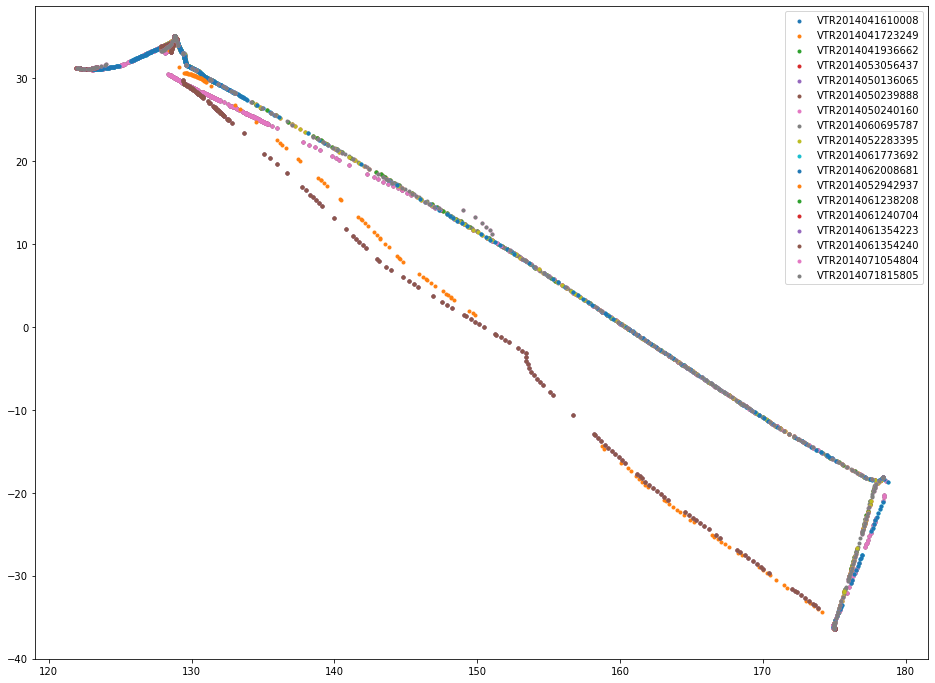

In [12]:
plt.figure(figsize=(16,12))
for idx in df_filtered['TRKG_NO'].unique():
    df_selected = df_filtered[df_filtered['TRKG_NO']==idx]
    plt.scatter(x=df_selected['LON'], y=df_selected['LAT'], marker='.')
plt.legend(df['TRKG_NO'].unique())
plt.show()

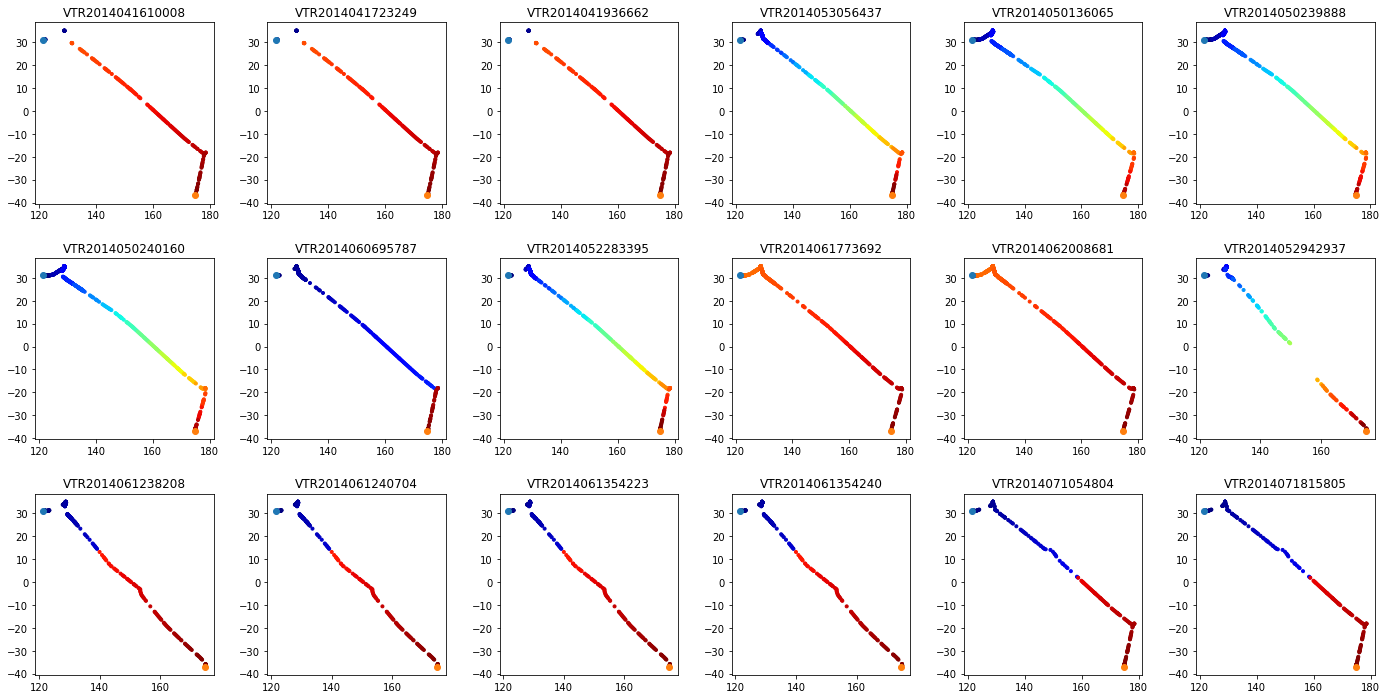

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

i = 0
for row in ax:
    for col in row:
        idx = df_filtered['TRKG_NO'].unique()[i]
        df_selected = df_filtered[df_filtered['TRKG_NO']==idx]
        col.scatter(x=df_selected['LON'], y=df_selected['LAT'], c=df_selected['AIS_DATETIME'], cmap='jet', marker='.')
        col.scatter(x=PATH_START[0], y=PATH_START[1])
        col.scatter(x=PATH_END[0], y=PATH_END[1])
        col.set_title(idx)
        i += 1

In [14]:
x_lat = np.asarray(df_filtered['LAT']).T
x_lon = np.asarray(df_filtered['LON']).T

x_edge = range(math.floor(min(x_lon)), math.ceil(max(x_lon))+1)
y_edge = range(math.floor(min(x_lat)), math.ceil(max(x_lat))+1)

In [15]:
df_matrix_list = []
for idx in df_filtered['TRKG_NO'].unique():
    df_selected = df_filtered[df_filtered['TRKG_NO']==idx]
    df_selected_lat = np.asarray(df_selected['LAT']).T
    df_selected_lon = np.asarray(df_selected['LON']).T
    
    H, xedges, yedges = np.histogram2d(df_selected_lon, df_selected_lat, bins=(x_edge, y_edge))
    H = H.T
    H_filp = np.flipud(H)
    
    df_matrix_list.append(H_filp)

In [16]:
H, xedges, yedges = np.histogram2d(x_lon, x_lat, bins=(x_edge, y_edge))
H = H.T
H_filp = np.flipud(H)

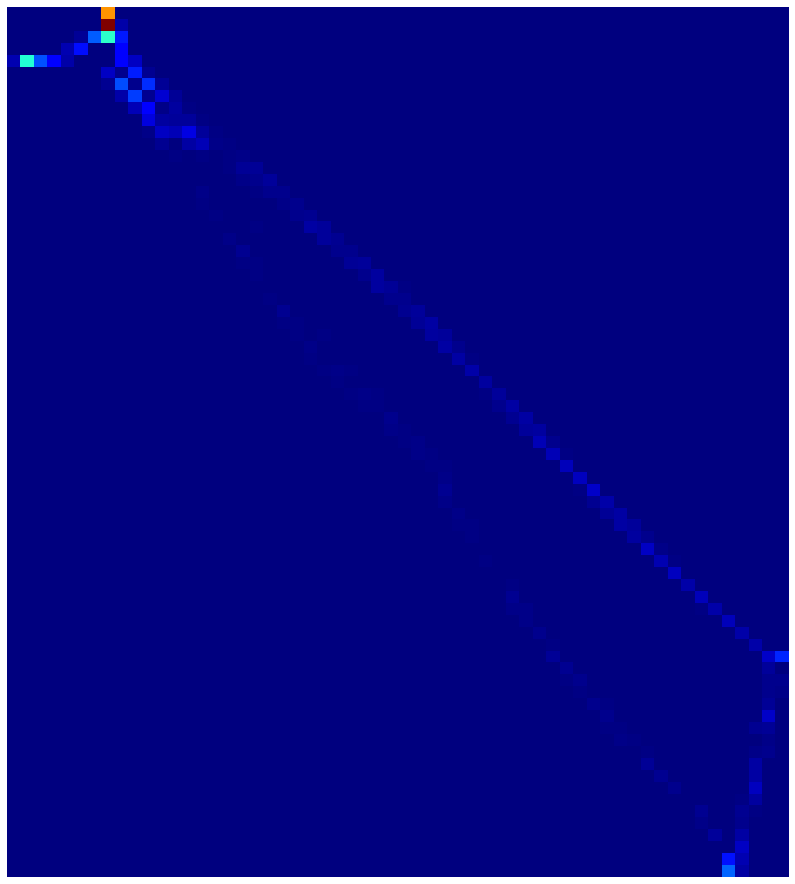

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,16))
ax.imshow(H_filp, cmap='jet', aspect='auto')
ax.axis('off')
plt.show()

In [18]:
k_means = KMeans(init='k-means++', n_clusters=3, n_init=10)

data = np.vstack([np.array(element.reshape(1,-1)) for element in df_matrix_list])
k_means.fit(data)

cluster = k_means.predict(data)

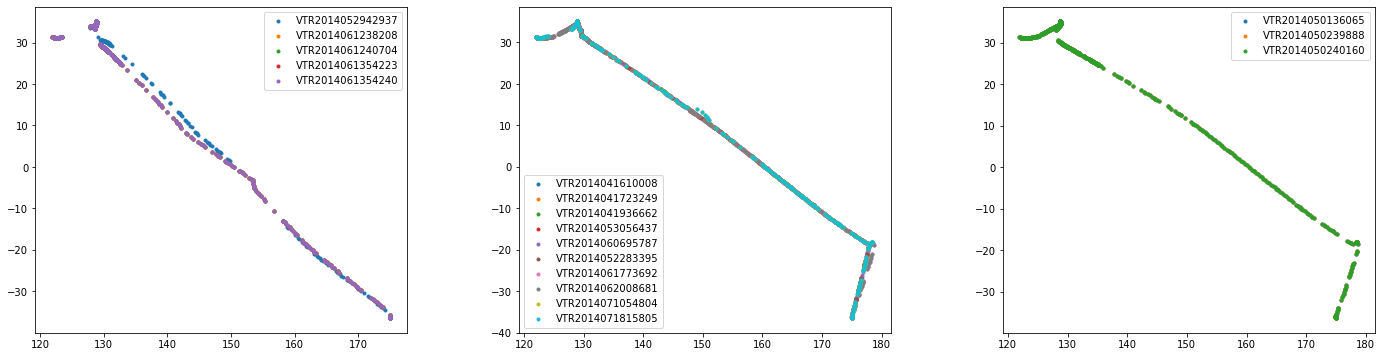

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,6))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

df_cluster_0 = []
df_cluster_1 = []
df_cluster_2 = []

legend_0 = []
legend_1 = []
legend_2 = []

for idx, c in zip(df_filtered['TRKG_NO'].unique(), cluster):
    df_selected = df_filtered[df_filtered['TRKG_NO']==idx]

    if c == 0:
        df_cluster_0.append(df_selected)
        ax[0].scatter(x=df_selected['LON'], y=df_selected['LAT'], marker='.')
        legend_0.append(idx)
    elif c == 1:
        df_cluster_1.append(df_selected)
        ax[1].scatter(x=df_selected['LON'], y=df_selected['LAT'], marker='.') 
        legend_1.append(idx)
    elif c == 2:
        df_cluster_2.append(df_selected)
        ax[2].scatter(x=df_selected['LON'], y=df_selected['LAT'], marker='.') 
        legend_2.append(idx)
        
ax[0].legend(legend_0)
ax[1].legend(legend_1)
ax[2].legend(legend_2)

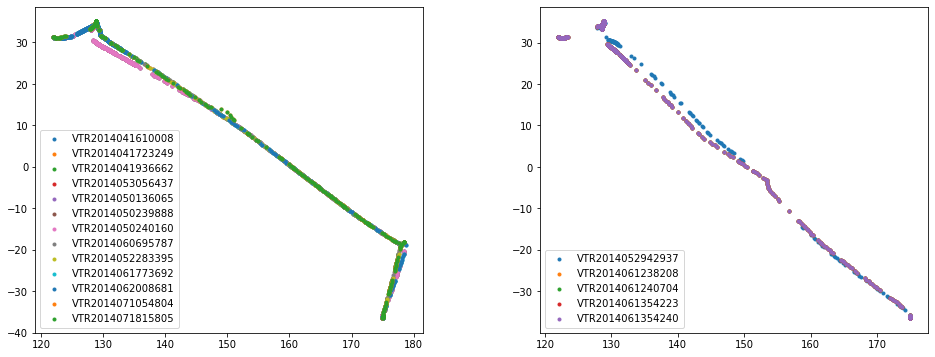

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

legend_0 = []
legend_1 = []

for idx, c in zip(df_filtered['TRKG_NO'].unique(), cluster):
    df_selected = df_filtered[df_filtered['TRKG_NO']==idx]

    if c == 1 or c == 2:
        ax[0].scatter(x=df_selected['LON'], y=df_selected['LAT'], marker='.')
        legend_0.append(idx)
    elif c == 0:
        ax[1].scatter(x=df_selected['LON'], y=df_selected['LAT'], marker='.') 
        legend_1.append(idx)
        
ax[0].legend(legend_0, loc=3)
ax[1].legend(legend_1, loc=3)

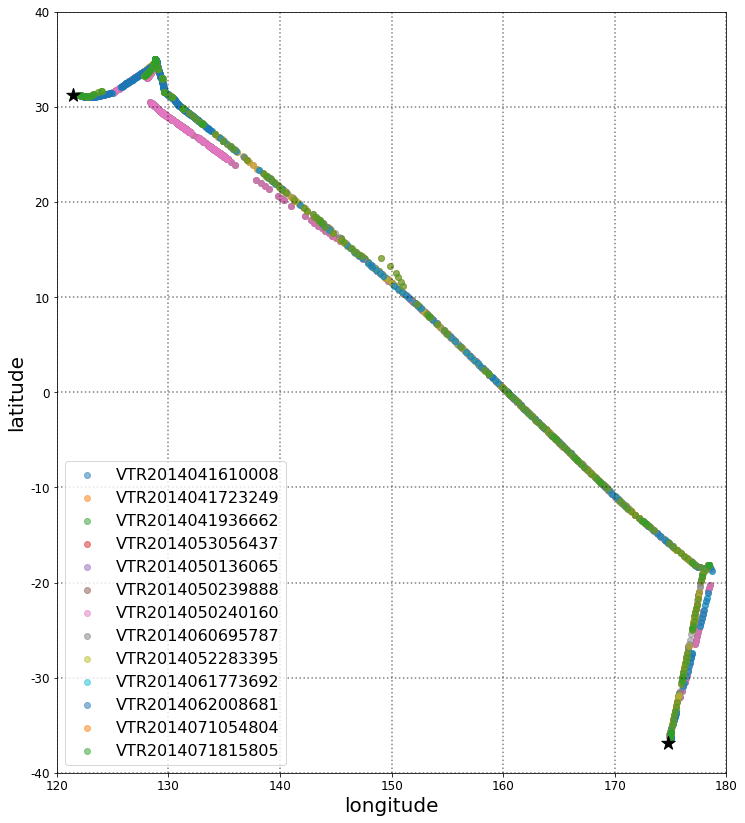

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,14))

legend_0 = []

for idx, c in zip(df_filtered['TRKG_NO'].unique(), cluster):
    df_selected = df_filtered[df_filtered['TRKG_NO']==idx]

    if c == 1 or c == 2:
        ax.scatter(x=df_selected['LON'], y=df_selected['LAT'], marker='o', alpha=0.5, label=idx)
        # legend_0.append(idx)
        
ax.scatter(PATH_START[0], PATH_START[1], c='black', marker='*', s=200)
ax.scatter(PATH_END[0], PATH_END[1], c='black', marker='*', s=200)
        
for h in np.arange(-40, 40+10, 10):
    ax.axhline(h, color='k', ls=':', alpha=0.5)
    
for v in np.arange(120, 180+10, 10):
    ax.axvline(v, color='k', ls=':', alpha=0.5)
        
ax.legend(loc=3, fontsize=16)

ax.set_xlim(120,180)
ax.set_xticks(np.arange(120, 180+10, 10))
ax.set_xticklabels(np.arange(120, 180+10, 10), fontsize=12)
ax.set_xlabel('longitude', fontsize=20)

ax.set_ylim(-40,40)
ax.set_yticks(np.arange(-40, 40+10, 10))
ax.set_yticklabels(np.arange(-40, 40+10, 10), fontsize=12)
ax.set_ylabel('latitude', fontsize=20)
plt.show()

In [22]:
df_target = pd.concat(df_cluster_1+df_cluster_2)

In [23]:
df_target

,TRKG_NO,MMSI_CD,VSL_NM,AIS_DATETIME,LAT,LON,SPD
62,VTR2014041610008,209752000_4,NOBLE REGOR,20140429054233,31.2543,121.9454,107.0
63,VTR2014041610008,209752000_4,NOBLE REGOR,20140429055154,31.2481,121.9832,110.0
64,VTR2014041610008,209752000_4,NOBLE REGOR,20140429060253,31.2409,122.0290,117.0
65,VTR2014041610008,209752000_4,NOBLE REGOR,20140429061227,31.2341,122.0720,122.0
66,VTR2014041610008,209752000_4,NOBLE REGOR,20140429062145,31.2189,122.1124,131.0
...,...,...,...,...,...,...,...
6318,VTR2014050240160,218575000_5,HANSA VICTORY,20140530232130,-36.2502,174.9288,100.0
6319,VTR2014050240160,218575000_5,HANSA VICTORY,20140530233203,-36.2835,174.9389,99.0
6320,VTR2014050240160,218575000_5,HANSA VICTORY,20140530234108,-36.3126,174.9475,100.0
6321,VTR2014050240160,218575000_5,HANSA VICTORY,20140530235208,-36.3472,174.9578,101.0


In [24]:
len(df_target['TRKG_NO'].unique()), len(df_target['MMSI_CD'].unique()), len(df_target['VSL_NM'].unique())

(13, 7, 3)

In [25]:
df_target[['LAT', 'LON']].to_csv('target_raw.csv', index=False)

In [26]:
x_lat_target = np.asarray(df_target['LAT']).T
x_lon_target = np.asarray(df_target['LON']).T

#x_edge = range(math.floor(min(x_lon)), math.ceil(max(x_lon))+1)
#y_edge = range(math.floor(min(x_lat)), math.ceil(max(x_lat))+1)

In [27]:
H_target, xedges, yedges = np.histogram2d(x_lon_target, x_lat_target, bins=(x_edge, y_edge))
H_target = H_target.T
H_target_filp = np.flipud(H_target)

In [28]:
H_target_filp.shape

(73, 58)

In [29]:
PATH_START_CELL = (math.floor(PATH_START[0]) - math.floor(min(x_lon)), math.ceil(max(x_lat)) - math.ceil(PATH_START[1]))
PATH_START_CELL

(0, 4)

In [30]:
PATH_END_CELL = (math.floor(PATH_END[0]) - math.floor(min(x_lon)), math.ceil(max(x_lat)) - math.ceil(PATH_END[1]))
PATH_END_CELL

(53, 72)

In [31]:
H_target_filp.shape

(73, 58)

In [32]:
73*58

4234

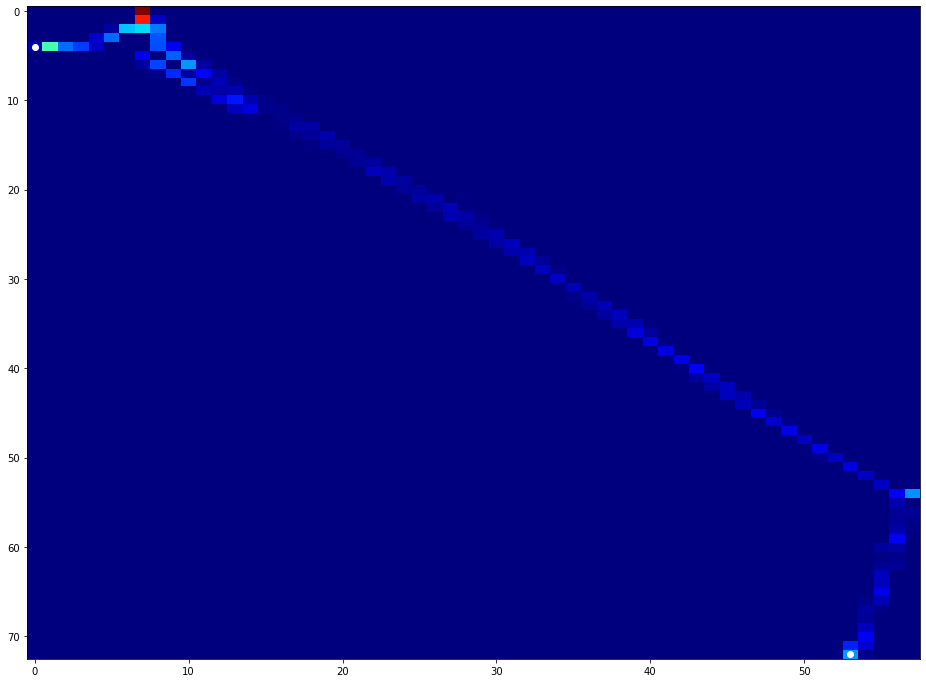

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,12))
ax.imshow(H_target_filp, cmap='jet', aspect='auto')
ax.scatter(PATH_START_CELL[0], PATH_START_CELL[1], c='white')
ax.scatter(PATH_END_CELL[0], PATH_END_CELL[1], c='white')

In [34]:
X = H_target_filp
X_csr = csr_matrix(X)
X_coo = X_csr.tocoo()

(array([135.,  11.,   8.,   2.,   1.,   0.,   0.,   0.,   1.,   1.]),
 array([  1. ,  44.4,  87.8, 131.2, 174.6, 218. , 261.4, 304.8, 348.2,
        391.6, 435. ]),
 <BarContainer object of 10 artists>)

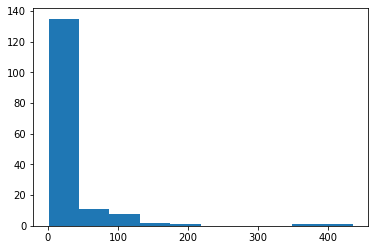

In [35]:
plt.hist(X_coo.data)

In [36]:
np.sum(X_csr.data > np.quantile(X_coo.data, 0.9)), len(X_csr.data)

(16, 159)

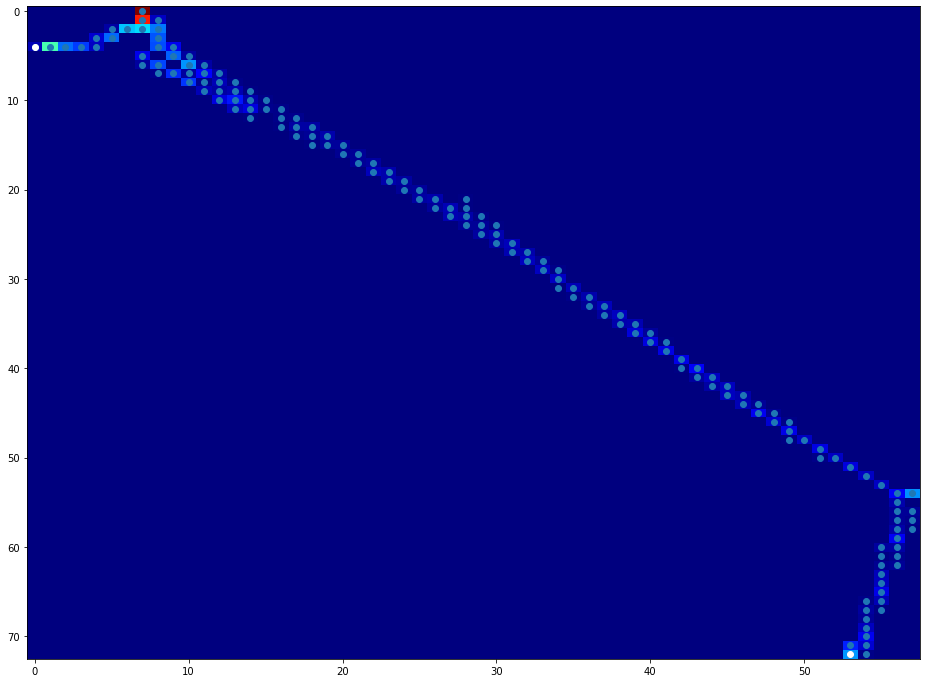

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,12))
ax.imshow(H_target_filp, cmap='jet', aspect='auto')
ax.scatter(X_coo.col, X_coo.row)
ax.scatter(PATH_START_CELL[0], PATH_START_CELL[1], c='white')
ax.scatter(PATH_END_CELL[0], PATH_END_CELL[1], c='white')

In [38]:
X_x = []
X_y = []
X_data = []

for col, row, data in zip(X_coo.col, X_coo.row, X_coo.data):
    if data > 10: # np.median(X_coo.data):
        X_x.append(col)
        X_y.append(row)
        X_data.append(data)

X_x = np.array(X_x)
X_y = np.array(X_y)
X_data = np.array(X_data)

In [39]:
X_cell = np.vstack([X_x, X_y]).T
clustering = DBSCAN(eps=2, min_samples=3, metric='manhattan').fit(X_cell)
np.unique(clustering.labels_)

array([0, 1, 2, 3, 4, 5])

In [40]:
X_cell_cluster = np.hstack([X_cell, X_data.reshape(-1,1), clustering.labels_.reshape(-1,1)])

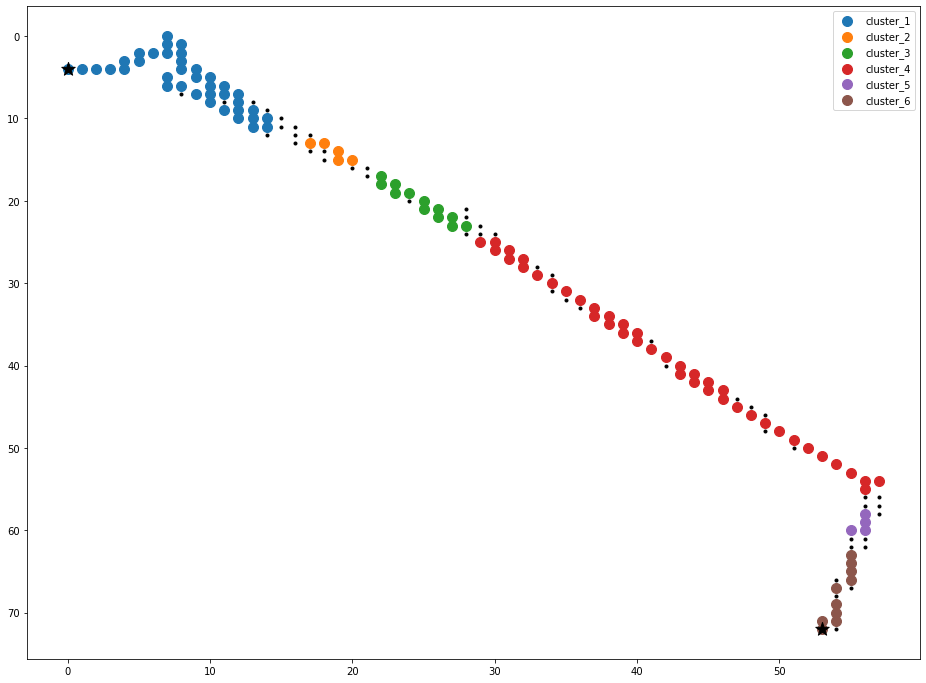

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,12))
#ax.imshow(H_target_filp, cmap='jet', aspect='auto')
ax.scatter(X_coo.col, X_coo.row, color = 'k', marker='.', alpha=1.0)
for cluster in np.unique(clustering.labels_):
    cluster_idx = np.where(X_cell_cluster[:,3]==cluster)[0]
    ax.scatter(X_cell[cluster_idx][:,0], X_cell[cluster_idx][:,1], cmap='jet', marker='o', s=100, label='cluster_{}'.format(cluster+1))
ax.scatter(PATH_START_CELL[0], PATH_START_CELL[1], c='black', marker='*', s=200)
ax.scatter(PATH_END_CELL[0], PATH_END_CELL[1], c='black', marker='*', s=200)
ax.invert_yaxis()
plt.legend()
plt.show()

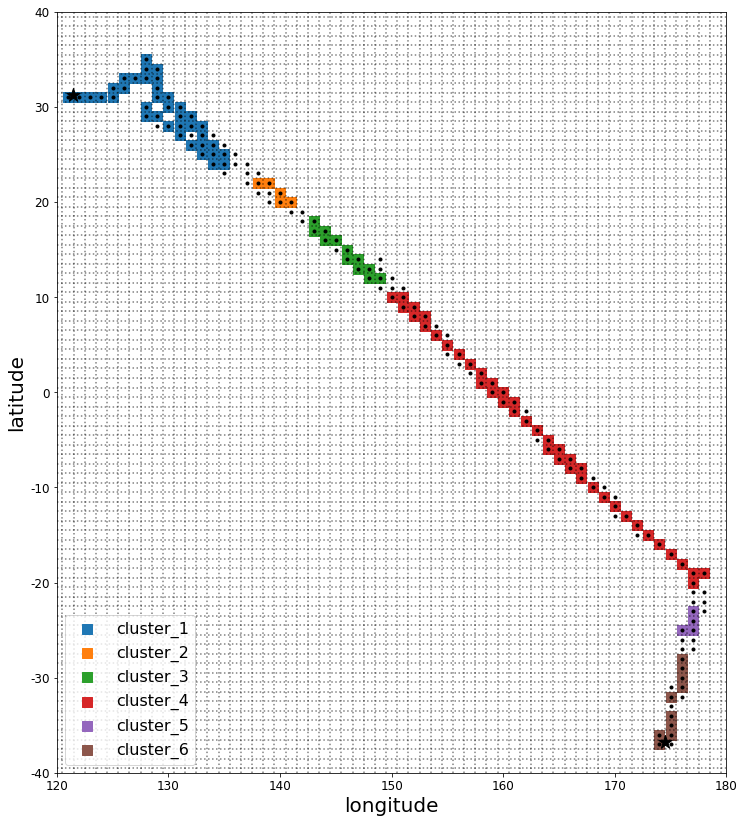

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,14))
#ax.imshow(H_target_filp, cmap='jet', aspect='auto')
# ax.scatter(X_coo.col+round(PATH_START[0]), X_coo.row-round(PATH_START[1])-4, color = 'k', marker='.', alpha=1.0)
for cluster in np.unique(clustering.labels_):
    cluster_idx = np.where(X_cell_cluster[:,3]==cluster)[0]
    ax.scatter(X_cell[cluster_idx][:,0]+round(PATH_START[0]), X_cell[cluster_idx][:,1]-round(PATH_START[1])-4, cmap='jet', marker='s', s=100, label='cluster_{}'.format(cluster+1))
ax.scatter(X_coo.col+round(PATH_START[0]), X_coo.row-round(PATH_START[1])-4, color = 'k', marker='.', alpha=1.0)
ax.scatter(PATH_START_CELL[0]+PATH_START[0], PATH_START_CELL[1]-PATH_START[1]-4, c='black', marker='*', s=200)
ax.scatter(PATH_END_CELL[0]+PATH_START[0], PATH_END_CELL[1]-PATH_START[1]-4, c='black', marker='*', s=200)
ax.invert_yaxis()

for h in np.arange(-40-0.5, 40+1, 1):
    ax.axhline(h, color='k', ls=':', alpha=0.5)
    
for v in np.arange(120-0.5, 180+1, 1):
    ax.axvline(v, color='k', ls=':', alpha=0.5)

ax.legend(loc=3, fontsize=16)
    
ax.set_xlim(120,180)
ax.set_xticks(np.arange(120, 180+10, 10))
ax.set_xticklabels(np.arange(120, 180+10, 10), fontsize=12)
ax.set_xlabel('longitude', fontsize=20)

ax.set_ylim(40,-40)
ax.set_yticks(np.arange(-40, 40+10, 10))
ax.set_yticklabels(np.arange(-40, 40+10, 10)[::-1], fontsize=12)
ax.set_ylabel('latitude', fontsize=20)

plt.show()

In [43]:
X_cell_cluster = np.hstack([X_cell, X_data.reshape(-1,1), clustering.labels_.reshape(-1,1)])

In [44]:
imp_cell = []
for cluster in np.unique(clustering.labels_):
    cluster_idx = np.where(X_cell_cluster[:,3]==cluster)[0]
    imp_cell.append(X_cell_cluster[cluster_idx[0],:]) #first cell
    imp_cell.append(X_cell_cluster[cluster_idx][np.argmax(X_cell_cluster[cluster_idx][:,2])]) #max record cell
    imp_cell.append(X_cell_cluster[cluster_idx[-1],:]) #last cell
imp_cell = np.array(imp_cell)

In [45]:
len(imp_cell)

18

In [46]:
imp_cell_start = np.array([PATH_START_CELL[0], PATH_START_CELL[1],-1, -1])
imp_cell_end = np.array([PATH_END_CELL[0], PATH_END_CELL[1],-1, -1])
imp_cell = np.vstack([imp_cell_start, imp_cell, imp_cell_end])

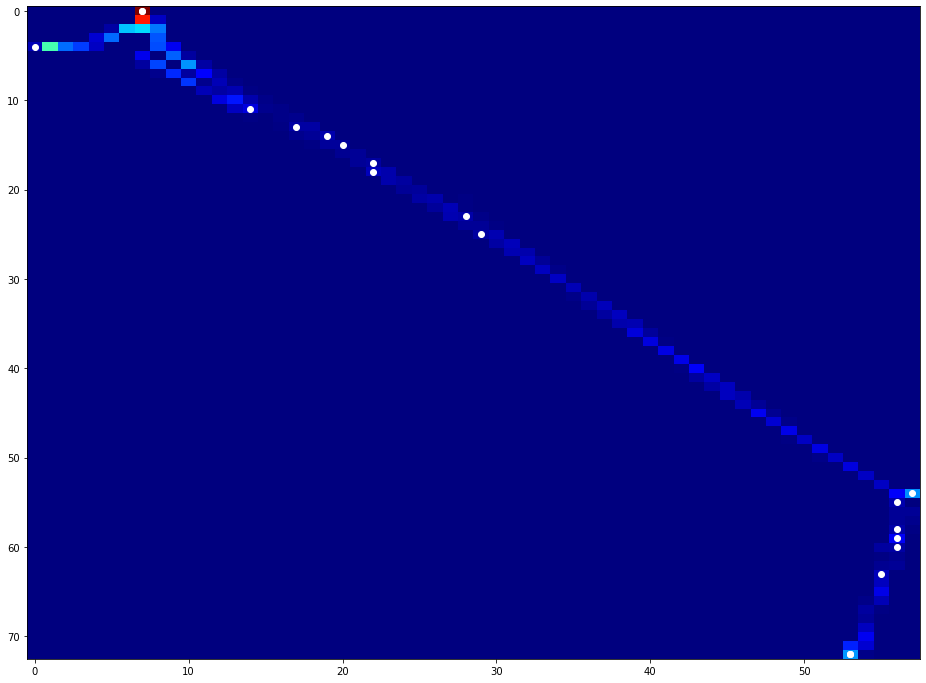

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,12))
ax.imshow(H_target_filp, cmap='jet', aspect='auto')
ax.scatter(imp_cell[:,0], imp_cell[:,1], c='white')

In [48]:
def get_n_routes(grid):
    n_routes = math.factorial(grid.shape[0]-1+grid.shape[1]-1)/math.factorial(grid.shape[0]-1)/math.factorial(grid.shape[1]-1)
    return int(n_routes)

In [49]:
N_ROUTES_MAX = 500
grid_list = []
grid_info_list = []

for (x_s,y_s), (x_e,y_e) in zip(imp_cell[:-1][:,0:2], imp_cell[1:][:,0:2]):
    if (x_s,y_s) == (x_e,y_e):
        continue

    x_d = 1 #rightward
    if x_s >= x_e:
        tmp = x_s
        x_s = x_e
        x_e = tmp
        x_d = -1 #leftward
    y_d = 1 #downward
    if y_s >= y_e:
        tmp = y_s
        y_s = y_e
        y_e = tmp
        y_d = -1 #upward

    x_s, y_s, x_e, y_e = int(x_s), int(y_s), int(x_e), int(y_e)
    
    grid = H_target_filp[y_s:y_e+1, x_s:x_e+1] #matrix indexing (row,col)
    m_dist = grid.shape[0]-1 + grid.shape[1]-1        
    n_routes = get_n_routes(grid)
    
    if n_routes <= N_ROUTES_MAX:
        grid_list.append(grid)
        grid_info_list.append([x_s, y_s, x_e, y_e, x_d, y_d])
    else:
        # if n_routes is larger than threshold, divide it into smaller one
        sub_grids = []
        while n_routes > N_ROUTES_MAX:
            grid_coo = csr_matrix(grid).tocoo()
            grid_value = np.array([grid_coo.data, grid_coo.row, grid_coo.col]).T
            grid_value_sorted = grid_value[grid_value[:,0].argsort()[::-1]]

            for val, row, col in grid_value_sorted:
                if row+col < 6:
                    continue
                if row+col < 12:
                    row_mid = int(row)
                    col_mid = int(col)
                    break

            sub_grid_1 = grid[0:row_mid+1, 0:col_mid+1]
            sub_grid_2 = grid[row_mid:grid.shape[0]+1, col_mid:grid.shape[1]+1]

            sub_grids.append(sub_grid_1)
            grid = sub_grid_2
            m_dist = grid.shape[0]-1 + grid.shape[1]-1
            n_routes = get_n_routes(grid)
        sub_grids.append(grid)

        for sub in sub_grids:
            grid_list.append(sub)
            x_e = x_s + sub.shape[1]-1
            y_e = y_s + sub.shape[0]-1
            grid_info_list.append([x_s, y_s, x_e, y_e, x_d, y_d])
            x_s = x_e
            y_s = y_e
            n_routes = math.factorial(sub.shape[0]-1+sub.shape[1]-1)/math.factorial(sub.shape[0]-1)/math.factorial(sub.shape[1]-1)

In [50]:
grid_info_list_adjust = []

for x_s, y_s, x_e, y_e, x_d, y_d in grid_info_list:
    if x_d == -1:
        tmp = x_s
        x_s = x_e
        x_e = tmp
    if y_d == -1:
        tmp = y_s
        y_s = y_e
        y_e = tmp
        y_d = -1 #upward
    grid_info_list_adjust.append([x_s, y_s, x_e, y_e, x_d, y_d])
    
grid_info_list = grid_info_list_adjust
grid_info_list

[[0, 4, 7, 0, 1, -1],
 [7, 0, 10, 6, 1, 1],
 [10, 6, 14, 11, 1, 1],
 [14, 11, 17, 13, 1, 1],
 [17, 13, 19, 14, 1, 1],
 [19, 14, 20, 15, 1, 1],
 [20, 15, 22, 17, 1, 1],
 [22, 17, 22, 18, -1, 1],
 [22, 18, 28, 23, 1, 1],
 [28, 23, 29, 25, 1, 1],
 [29, 25, 34, 30, 1, 1],
 [34, 30, 39, 36, 1, 1],
 [39, 36, 43, 40, 1, 1],
 [43, 40, 47, 45, 1, 1],
 [47, 45, 51, 49, 1, 1],
 [51, 49, 57, 54, 1, 1],
 [57, 54, 56, 55, -1, 1],
 [56, 55, 56, 58, -1, 1],
 [56, 58, 56, 59, -1, 1],
 [56, 59, 56, 60, -1, 1],
 [56, 60, 55, 63, -1, 1],
 [55, 63, 53, 72, -1, 1]]

In [51]:
for (x_s, y_s, x_e, y_e, x_d, y_d), grid in zip(grid_info_list, grid_list):
    print([x_s, y_s, x_e, y_e, x_d, y_d], grid.shape)

[0, 4, 7, 0, 1, -1] (5, 8)
[7, 0, 10, 6, 1, 1] (7, 4)
[10, 6, 14, 11, 1, 1] (6, 5)
[14, 11, 17, 13, 1, 1] (3, 4)
[17, 13, 19, 14, 1, 1] (2, 3)
[19, 14, 20, 15, 1, 1] (2, 2)
[20, 15, 22, 17, 1, 1] (3, 3)
[22, 17, 22, 18, -1, 1] (2, 1)
[22, 18, 28, 23, 1, 1] (6, 7)
[28, 23, 29, 25, 1, 1] (3, 2)
[29, 25, 34, 30, 1, 1] (6, 6)
[34, 30, 39, 36, 1, 1] (7, 6)
[39, 36, 43, 40, 1, 1] (5, 5)
[43, 40, 47, 45, 1, 1] (6, 5)
[47, 45, 51, 49, 1, 1] (5, 5)
[51, 49, 57, 54, 1, 1] (6, 7)
[57, 54, 56, 55, -1, 1] (2, 2)
[56, 55, 56, 58, -1, 1] (4, 1)
[56, 58, 56, 59, -1, 1] (2, 1)
[56, 59, 56, 60, -1, 1] (2, 1)
[56, 60, 55, 63, -1, 1] (4, 2)
[55, 63, 53, 72, -1, 1] (10, 3)


In [52]:
len(grid_list)

22

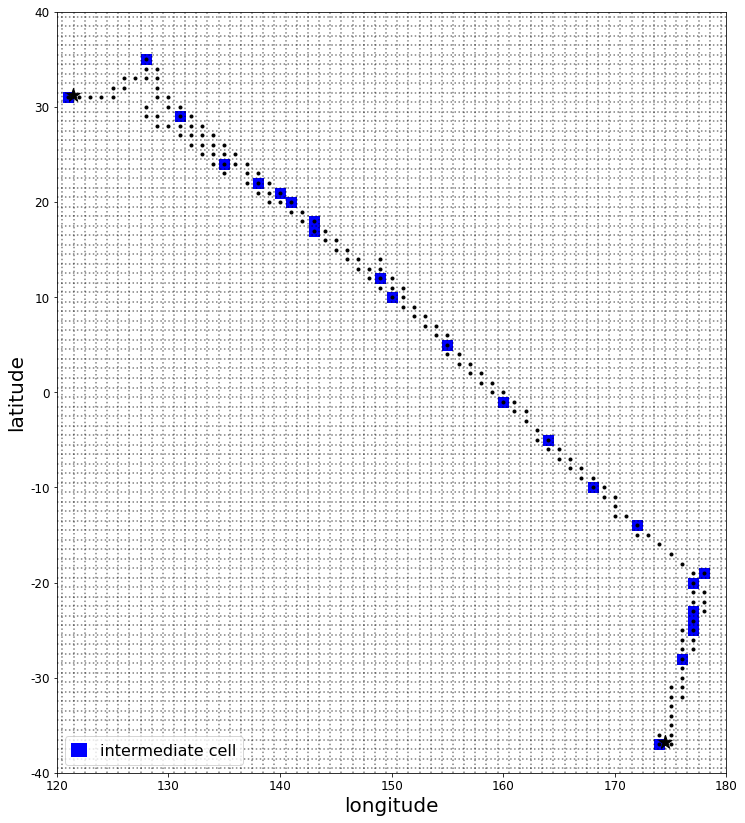

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,14))
#ax.imshow(H_target_filp, cmap='jet', aspect='auto')
# ax.scatter(X_coo.col+round(PATH_START[0]), X_coo.row-round(PATH_START[1])-4, color = 'k', marker='.', alpha=1.0)
for (x_s, y_s, x_e, y_e, x_d, y_d) in grid_info_list:
    ax.scatter(x_s+round(PATH_START[0]), y_s-round(PATH_START[1])-4, color='b', marker='s', alpha=1, s=100)
    ax.scatter(x_e+round(PATH_START[0]), y_e-round(PATH_START[1])-4, color='b', marker='s', alpha=1, s=100)
ax.scatter(X_coo.col+round(PATH_START[0]), X_coo.row-round(PATH_START[1])-4, color = 'k', marker='.', alpha=1.0)
ax.scatter(PATH_START_CELL[0]+PATH_START[0], PATH_START_CELL[1]-PATH_START[1]-4, c='black', marker='*', s=200)
ax.scatter(PATH_END_CELL[0]+PATH_START[0], PATH_END_CELL[1]-PATH_START[1]-4, c='black', marker='*', s=200)
ax.invert_yaxis()

for h in np.arange(-40-0.5, 40+1, 1):
    ax.axhline(h, color='k', ls=':', alpha=0.5)
    
for v in np.arange(120-0.5, 180+1, 1):
    ax.axvline(v, color='k', ls=':', alpha=0.5)


c = [ mpatches.Rectangle((0.5, 0.5), 1, 1, facecolor='b', edgecolor="none")]
ax.legend(c, ['intermediate cell'], loc=3, fontsize=16, handlelength=1, handleheight=1)
    
ax.set_xlim(120,180)
ax.set_xticks(np.arange(120, 180+10, 10))
ax.set_xticklabels(np.arange(120, 180+10, 10), fontsize=12)
ax.set_xlabel('longitude', fontsize=20)

ax.set_ylim(40,-40)
ax.set_yticks(np.arange(-40, 40+10, 10))
ax.set_yticklabels(np.arange(-40, 40+10, 10)[::-1], fontsize=12)
ax.set_ylabel('latitude', fontsize=20)

plt.show()

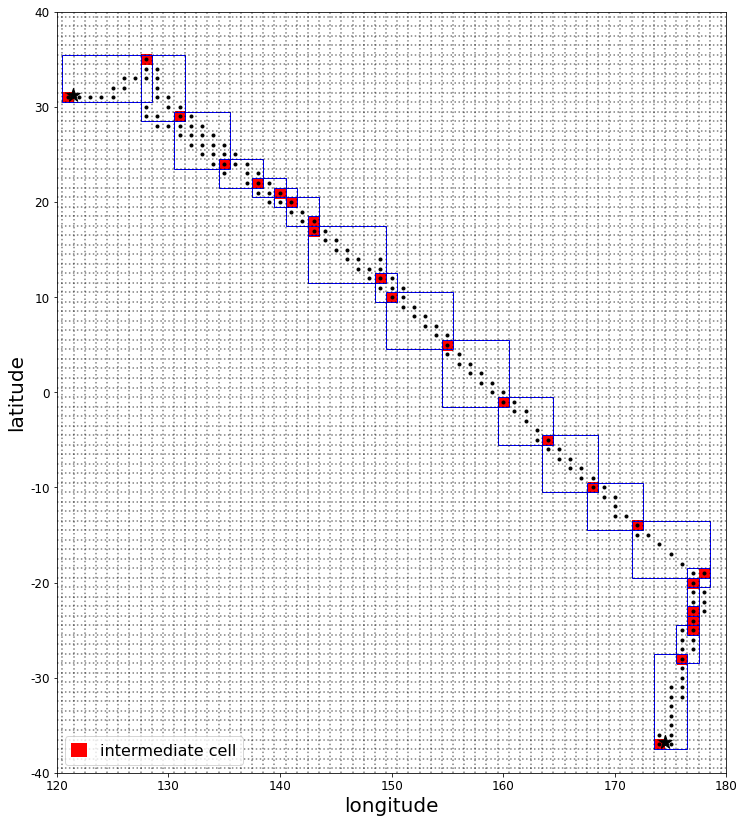

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,14))
#ax.imshow(H_target_filp, cmap='jet', aspect='auto')
# ax.scatter(X_coo.col+round(PATH_START[0]), X_coo.row-round(PATH_START[1])-4, color = 'k', marker='.', alpha=1.0)
for (x_s, y_s, x_e, y_e, x_d, y_d) in grid_info_list:
    ax.scatter(x_s+round(PATH_START[0]), y_s-round(PATH_START[1])-4, color='r', marker='s', alpha=1, s=100)
    ax.scatter(x_e+round(PATH_START[0]), y_e-round(PATH_START[1])-4, color='r', marker='s', alpha=1, s=100)

    # Create a Rectangle patch
    rect = mpatches.Rectangle((min(x_s,x_e)+round(PATH_START[0])-0.5, min(y_s, y_e)-round(PATH_START[1])-4-0.5),\
                             abs(x_e-x_s)+1, abs(y_e-y_s)+1, linewidth=1, edgecolor='b', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)   
    
ax.scatter(X_coo.col+round(PATH_START[0]), X_coo.row-round(PATH_START[1])-4, color = 'k', marker='.', alpha=1.0)
ax.scatter(PATH_START_CELL[0]+PATH_START[0], PATH_START_CELL[1]-PATH_START[1]-4, c='black', marker='*', s=200)
ax.scatter(PATH_END_CELL[0]+PATH_START[0], PATH_END_CELL[1]-PATH_START[1]-4, c='black', marker='*', s=200)
ax.invert_yaxis()

for h in np.arange(-40-0.5, 40+1, 1):
    ax.axhline(h, color='k', ls=':', alpha=0.5)
    
for v in np.arange(120-0.5, 180+1, 1):
    ax.axvline(v, color='k', ls=':', alpha=0.5)


c = [ mpatches.Rectangle((0.5, 0.5), 1, 1, facecolor='r', edgecolor="none")]
ax.legend(c, ['intermediate cell'], loc=3, fontsize=16, handlelength=1, handleheight=1)
    
ax.set_xlim(120,180)
ax.set_xticks(np.arange(120, 180+10, 10))
ax.set_xticklabels(np.arange(120, 180+10, 10), fontsize=12)
ax.set_xlabel('longitude', fontsize=20)

ax.set_ylim(40,-40)
ax.set_yticks(np.arange(-40, 40+10, 10))
ax.set_yticklabels(np.arange(-40, 40+10, 10)[::-1], fontsize=12)
ax.set_ylabel('latitude', fontsize=20)

plt.show()

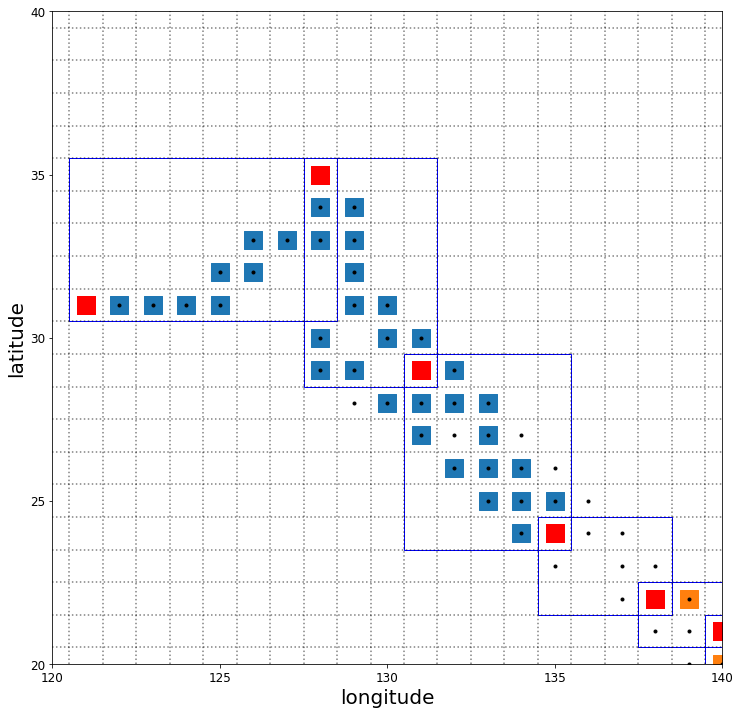

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12))
#ax.imshow(H_target_filp, cmap='jet', aspect='auto')
# ax.scatter(X_coo.col+round(PATH_START[0]), X_coo.row-round(PATH_START[1])-4, color = 'k', marker='.', alpha=1.0)
for cluster in np.unique(clustering.labels_):
    cluster_idx = np.where(X_cell_cluster[:,3]==cluster)[0]
    ax.scatter(X_cell[cluster_idx][:,0]+round(PATH_START[0]), X_cell[cluster_idx][:,1]-round(PATH_START[1])-4, cmap='jet', marker='s', s=300, label='cluster_{}'.format(cluster+1))
ax.scatter(X_coo.col+round(PATH_START[0]), X_coo.row-round(PATH_START[1])-4, color = 'k', marker='.', alpha=1.0)
# ax.scatter(PATH_START_CELL[0]+PATH_START[0], PATH_START_CELL[1]-PATH_START[1]-4, c='black', marker='*', s=200)
# ax.scatter(PATH_END_CELL[0]+PATH_START[0], PATH_END_CELL[1]-PATH_START[1]-4, c='black', marker='*', s=200)
ax.invert_yaxis()

for (x_s, y_s, x_e, y_e, x_d, y_d) in grid_info_list:
    ax.scatter(x_s+round(PATH_START[0]), y_s-round(PATH_START[1])-4, color='r', marker='s', alpha=1, s=300)
    ax.scatter(x_e+round(PATH_START[0]), y_e-round(PATH_START[1])-4, color='r', marker='s', alpha=1, s=300)

    # Create a Rectangle patch
    rect = mpatches.Rectangle((min(x_s,x_e)+round(PATH_START[0])-0.5, min(y_s, y_e)-round(PATH_START[1])-4-0.5),\
                             abs(x_e-x_s)+1, abs(y_e-y_s)+1, linewidth=1, edgecolor='b', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)  

for h in np.arange(-40-0.5, 40+1, 1):
    ax.axhline(h, color='k', ls=':', alpha=0.5)
    
for v in np.arange(120-0.5, 180+1, 1):
    ax.axvline(v, color='k', ls=':', alpha=0.5)

# ax.legend([], loc=3, fontsize=16)
    
ax.set_xlim(120,140)
ax.set_xticks(np.arange(120, 140+5, 5))
ax.set_xticklabels(np.arange(120, 140+5, 5), fontsize=12)
ax.set_xlabel('longitude', fontsize=20)

ax.set_ylim(-20,-40)
ax.set_yticks(np.arange(-40, -20+5, 5))
ax.set_yticklabels(np.arange(20, 40+5, 5)[::-1], fontsize=12)
ax.set_ylabel('latitude', fontsize=20)

plt.show()

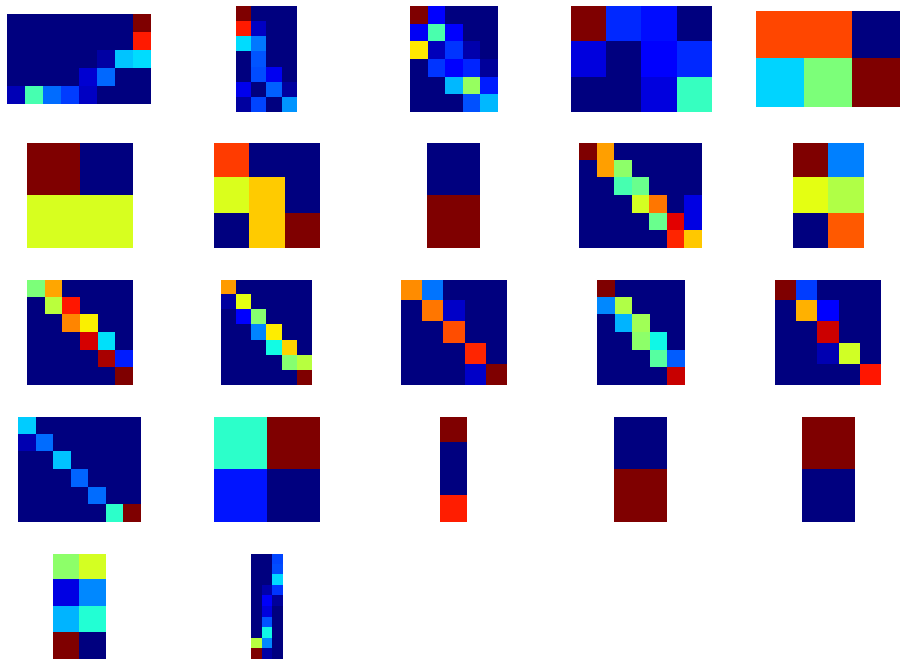

In [56]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(16,12))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

i = 0
for row in ax:
    for col in row:
        if i == len(grid_list):
            col.plot()
            col.axis('off')
            continue
        col.imshow(grid_list[i], cmap='jet')
        #for (j,i),label in np.ndenumerate(grid_list[i]):
        #    col.text(i,j,int(label),ha='center',va='center')
        col.axis('off')
        i += 1

In [57]:
grid_idx = ["{0:0=2d}".format(i) for i in range(len(grid_list))]

for grid, idx in zip(grid_list, grid_idx):
    pd.DataFrame(grid).to_csv(str('out/grid'+idx+'.csv'), index=False, header=False)

In [58]:
import pickle

out_name = 'out/grid_info_list'
with open(out_name, 'wb') as f:
    pickle.dump(grid_info_list, f)